# **Brain tumor 3D segmentation**

In this colab, we construct a training workflow for multi-labels brain tumor segmentation task.

- We use the Decathlon dataset: http://medicaldecathlon.com/

- 3D SegResNet model.

- Dice loss function.

- Mean Dice metric.


**The Target:** Gliomas brain tumor segmentation - necrotic/active tumour and oedema.

**Modality:** Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w).

**Challenge:** Complex and heterogeneously-located targets.


 *Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right). (Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))*

 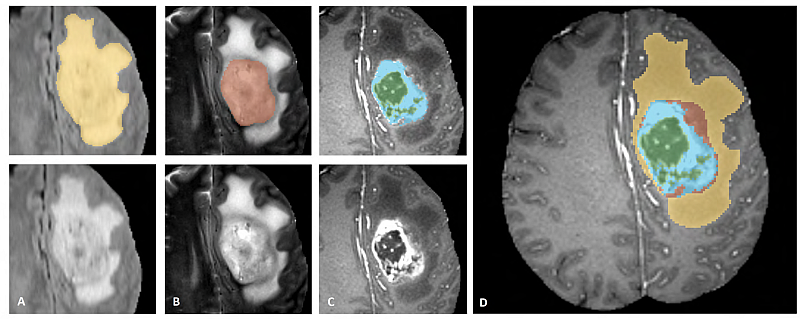

 The image patches show from left to right:

1. The whole tumor (yellow) visible in T2-FLAIR (Fig.A).

2. The tumor core (red) visible in T2 (Fig.B).

3. The enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).

4. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).



## 🛠️ Setup and Installation

### ↳ Installing MONAI and Weights and Biases

In [ ]:
!python -c "import monai" || pip install -q -U "monai[nibabel, tqdm]"
!python -c "import wandb" || pip install -q -U wandb

In [ ]:
#maksure that we are using GPU
!nvidia-smi

### ↳ Importing Python and Pytorch libraries

In [ ]:
import os
import numpy as np
import torch
from tqdm.auto import tqdm

### ↳ Importing MONAI and Weights and Biases libraries

In [ ]:
import wandb
from monai.apps import DecathlonDataset
from monai.data import DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.config import print_config
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.utils import set_determinism
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
print_config()

### ↳ Authenticating the colab to use W&B

In [ ]:
wandb.login()

### ↳ Intializing W&B Run to start tracking our experiment

In [ ]:
wandb.init(project="3D-brain-tumor-segmentation")

## 🎛 Configurations and hyperparameters


In [ ]:
config = wandb.config
config.seed = 0
config.roi_size = [224, 224, 144]
config.batch_size = 1
config.num_workers = 4
config.max_train_images_visualized = 4
config.max_val_images_visualized = 4
config.dice_loss_smoothen_numerator = 0
config.dice_loss_smoothen_denominator = 1e-5
config.dice_loss_squared_prediction = True
config.dice_loss_target_onehot = False
config.dice_loss_apply_sigmoid = True
config.initial_learning_rate = 1e-4
config.weight_decay = 1e-5
config.max_train_epochs = 50
config.validation_intervals = 1
config.inference_roi_size = (128, 128, 64)
config.max_prediction_images_visualized = 20


In [ ]:
set_determinism(seed=config.seed)

## 💾 Dataset Loading and Transformations

### ↳ Creating data-directories

In [ ]:
config.dataset_dir = "./dataset/"
config.checkpoint_dir = "./checkpoints"
# Create directories
os.makedirs(config.dataset_dir, exist_ok=True)
os.makedirs(config.checkpoint_dir, exist_ok=True)

### ↳ Setting-up transformations

we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    Reference: https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

We set up pre-processing or transforms for training and validation datasets respectively.

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=config.roi_size, random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

# we will do the same transformation to validation set,excluding the data augementation transforms.
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

### ↳ Downloading Dataset & applying transformations

We will use the [DecathlonDataset](https://www.google.com/url?q=http%3A%2F%2Fmedicaldecathlon.com%2F) to automatically download and extract the dataset.

We will use Multimodal multisite MRI data (FLAIR, T1w, T1gd, T2w) to segment Gliomas, necrotic/active tumour, and oedema. The dataset consists of 750 4D volumes (484 Training + 266 Testing).

In [ ]:
train_dataset = DecathlonDataset(
    root_dir=config.dataset_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
val_dataset = DecathlonDataset(
    root_dir=config.dataset_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)

**Note:** Instead of applying the train_transform to the train_dataset, we have applied val_transform to both the training and validation datasets. This is because, before training, we would be visualizing samples from both the splits of the dataset.

### ↳ Visualizing Samples from the Dataset

We will use Weights & Biases to visualize our data volumes.To log segmentation masks in tables, we will need to provide a `wandb.Image`` object for each row in the table.

In [ ]:
def log_data_samples_into_tables(
    sample_image: np.array,
    sample_label: np.array,
    split: str = None,
    data_idx: int = None,
    table: wandb.Table = None,
):
    num_channels, _, _, num_slices = sample_image.shape
    with tqdm(total=num_slices, leave=False) as progress_bar:
        for slice_idx in range(num_slices):
            ground_truth_wandb_images = []
            for channel_idx in range(num_channels):
                ground_truth_wandb_images.append(
                    wandb.Image(
                        sample_image[channel_idx, :, :, slice_idx],
                        masks={
                            "ground-truth/Tumor-Core": {
                                "mask_data": sample_label[0, :, :, slice_idx],
                                "class_labels": {0: "background", 1: "Tumor Core"},
                            },
                            "ground-truth/Whole-Tumor": {
                                "mask_data": sample_label[1, :, :, slice_idx] * 2,
                                "class_labels": {0: "background", 2: "Whole Tumor"},
                            },
                            "ground-truth/Enhancing-Tumor": {
                                "mask_data": sample_label[2, :, :, slice_idx] * 3,
                                "class_labels": {0: "background", 3: "Enhancing Tumor"},
                            },
                        },
                    )
                )
            table.add_data(split, data_idx, slice_idx, *ground_truth_wandb_images)
            progress_bar.update(1)
    return table

In [ ]:
table = wandb.Table(
    columns=[
        "Split",
        "Data Index",
        "Slice Index",
        "Image-Channel-0",
        "Image-Channel-1",
        "Image-Channel-2",
        "Image-Channel-3",
    ]
)

In [ ]:
# Generate visualizations for train_dataset
max_samples = (
    min(config.max_train_images_visualized, len(train_dataset))
    if config.max_train_images_visualized > 0
    else len(train_dataset)
)
progress_bar = tqdm(
    enumerate(train_dataset[:max_samples]),
    total=max_samples,
    desc="Generating Train Dataset Visualizations:",
)
for data_idx, sample in progress_bar:
    sample_image = sample["image"].detach().cpu().numpy()
    sample_label = sample["label"].detach().cpu().numpy()
    table = log_data_samples_into_tables(
        sample_image,
        sample_label,
        split="train",
        data_idx=data_idx,
        table=table,
    )

# Generate visualizations for val_dataset
max_samples = (
    min(config.max_val_images_visualized, len(val_dataset))
    if config.max_val_images_visualized > 0
    else len(val_dataset)
)
progress_bar = tqdm(
    enumerate(val_dataset[:max_samples]),
    total=max_samples,
    desc="Generating Validation Dataset Visualizations:",
)
for data_idx, sample in progress_bar:
    sample_image = sample["image"].detach().cpu().numpy()
    sample_label = sample["label"].detach().cpu().numpy()
    table = log_data_samples_into_tables(
        sample_image,
        sample_label,
        split="val",
        data_idx=data_idx,
        table=table,
    )

# Log the table to your dashboard
wandb.log({"Tumor-Segmentation-Data": table})

The W&B dashboard will display the data in an interactive table, showing each channel of a data slice with its corresponding segmentation mask in each row.

![](https://drive.google.com/uc?id=1oQmBOE3ozmqM2ECvgDTHbJjR41NNTSco)

### ↳ Loading the Data

We create the PyTorch dataloaders for loading the data from the datasets. Note that before creating the dataloaders, we set the transform for train_dataset to train_transform to preprocess and transform the data for training.


Brain Tumor Images can be seen from W&B Dashboard. We can select from the table a particular slice from a data volume

In [ ]:
# apply train_transforms to the training dataset
train_dataset.transform = train_transform

# create the train_loader
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
)

# create the val_loader
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
)

## 🧠 🦾 Creating the SegResNet Model

We will be training a SegResNet model based on the paper [3D MRI brain tumor segmentation using autoencoder regularization](https://arxiv.org/pdf/1810.11654.pdf). We create the SegResNet model that comes implemented as a PyTorch Module as part of the monai.networks API.

In [ ]:
device = torch.device("cuda:0")

# create model
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

Below is the model Figure Taken from the paper [3D MRI brain tumor segmentation using autoencoder regularization](https://arxiv.org/pdf/1810.11654.pdf).

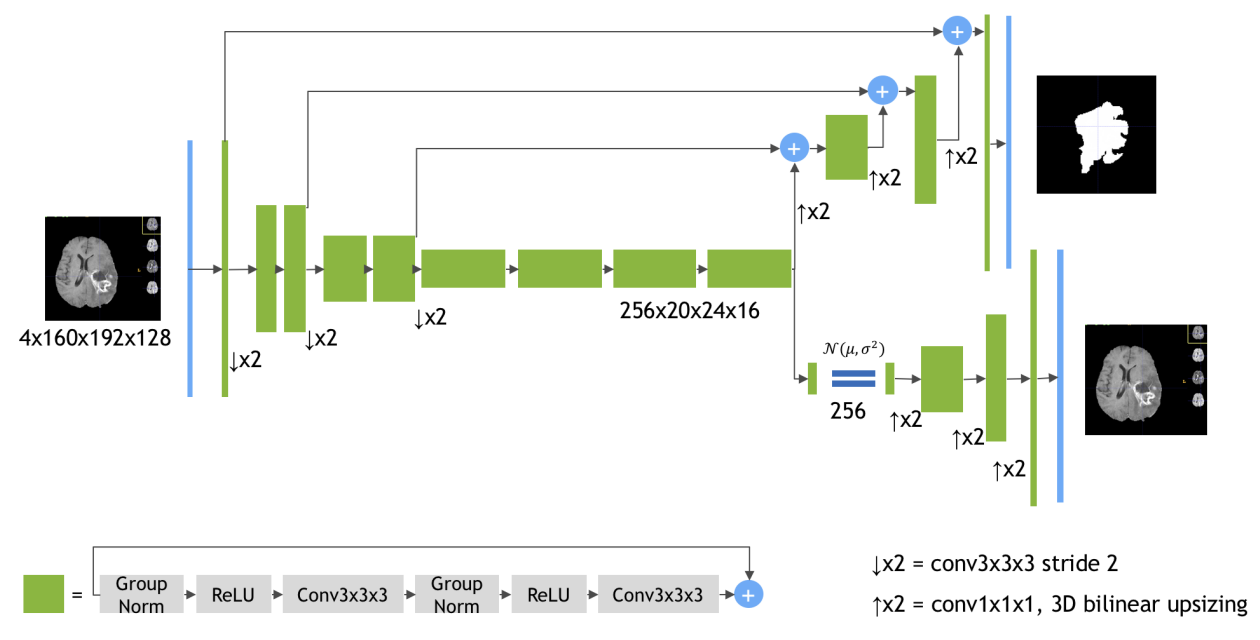

## 🚀 Adam Optimizer and learning rate Schedular

In [ ]:
# create optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    config.initial_learning_rate,
    weight_decay=config.weight_decay,
)

# create learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config.max_train_epochs
)

## 📉 Defining DiceLoss and Dice Metrics

`DiceLoss` using the `monai.losses` API and the corresponding dice metrics using the `monai.metrics` API.



In [ ]:
loss_function = DiceLoss(
    smooth_nr=config.dice_loss_smoothen_numerator,
    smooth_dr=config.dice_loss_smoothen_denominator,
    squared_pred=config.dice_loss_squared_prediction,
    to_onehot_y=config.dice_loss_target_onehot,
    sigmoid=config.dice_loss_apply_sigmoid,
)

\\begin{equation}
\mathbf{L}_{\text {dice }}=\frac{2 * \sum p_{\text {true }} * p_{\text {pred }}}{\sum p_{\text {true }}^2+\sum p_{\text {pred }}^2+\epsilon}
\end{equation}

In [ ]:
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# use automatic mixed-precision to accelerate training
scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

Inference function

In [ ]:
def inference(model, input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    with torch.cuda.amp.autocast():
        return _compute(input)

Defining some metrics to be logged with `wandb.log()` for tracking our training and validation experiments.

In [ ]:
wandb.define_metric("epoch/epoch_step")
wandb.define_metric("epoch/*", step_metric="epoch/epoch_step")
wandb.define_metric("batch/batch_step")
wandb.define_metric("batch/*", step_metric="batch/batch_step")
wandb.define_metric("validation/validation_step")
wandb.define_metric("validation/*", step_metric="validation/validation_step")

batch_step = 0
validation_step = 0
metric_values = []
metric_values_tumor_core = []
metric_values_whole_tumor = []
metric_values_enhanced_tumor = []

## 🏋️‍♂️ Training the model

In [ ]:
# Define a W&B Artifact object at each checkpoint epoch
epoch_progress_bar = tqdm(range(config.max_train_epochs), desc="Training:")

# Starting training loop
for epoch in epoch_progress_bar:
    model.train()
    epoch_loss = 0

    total_batch_steps = len(train_dataset) // train_loader.batch_size
    batch_progress_bar = tqdm(train_loader, total=total_batch_steps, leave=False)

    # Training Step
    for batch_data in batch_progress_bar:
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        batch_progress_bar.set_description(f"train_loss: {loss.item():.4f}:")
        ## Log batch-wise training loss to W&B
        wandb.log({"batch/batch_step": batch_step, "batch/train_loss": loss.item()})
        batch_step += 1

    lr_scheduler.step()
    epoch_loss /= total_batch_steps
    ## Log epoch-wise training loss and learning rate to W&B
    wandb.log(
        {
            "epoch/epoch_step": epoch,
            "epoch/mean_train_loss": epoch_loss,
            "epoch/learning_rate": lr_scheduler.get_last_lr()[0],
        }
    )
    epoch_progress_bar.set_description(f"Training: train_loss: {epoch_loss:.4f}:")

    # Validation and model checkpointing
    if (epoch + 1) % config.validation_intervals == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(model, val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric_values.append(dice_metric.aggregate().item())
            metric_batch = dice_metric_batch.aggregate()
            metric_values_tumor_core.append(metric_batch[0].item())
            metric_values_whole_tumor.append(metric_batch[1].item())
            metric_values_enhanced_tumor.append(metric_batch[2].item())
            dice_metric.reset()
            dice_metric_batch.reset()

            checkpoint_path = os.path.join(config.checkpoint_dir, "model.pth")
            torch.save(model.state_dict(), checkpoint_path)

            # Create a new artifact for each epoch
            artifact = wandb.Artifact(
                name=f"{wandb.run.id}-checkpoint-epoch-{epoch}", type="model"
            )

            # Log and version model checkpoints using W&B artifacts.
            artifact.add_file(local_path=checkpoint_path)
            wandb.log_artifact(artifact, aliases=[f"epoch_{epoch}"])

            # Log validation metrics to W&B dashboard.
            wandb.log(
                {
                    "validation/validation_step": validation_step,
                    "validation/mean_dice": metric_values[-1],
                    "validation/mean_dice_tumor_core": metric_values_tumor_core[-1],
                    "validation/mean_dice_whole_tumor": metric_values_whole_tumor[-1],
                    "validation/mean_dice_enhanced_tumor": metric_values_enhanced_tumor[-1],
                }
            )
            validation_step += 1


 We can track all the metrics associated with our training and validation process in W&B Dashboard Workspace.


![](https://drive.google.com/uc?id=1KxVZ5BeeSBZ6J-zgqsoseapaDOr_RRXT)

If we navigate to the artifacts tab in the W&B run dashboard, we will be able to access the different versions of model checkpoint artifacts that we logged during training. We can view related informations in Metadata such as batch size - learning rate - number of epochs - training loss....


![](https://drive.google.com/uc?id=1QV7ElJetiC4577pNVoQvX_SZn9rC-cIr)

## 🕵🏻 Inference

Using the artifacts interface, we can select which version of the artifact is the best model checkpoint, in this case, the version of the model artifact with the best epoch-wise mean training loss and load the checkpoint state dictionary to the model.

In [ ]:
model_artifact = wandb.use_artifact('amribrahim-amer-2024/3D-brain-tumor-segmentation/lb4ms8fm-checkpoint-epoch-49:v0', type='model')
model_artifact_dir = model_artifact.download()
model.load_state_dict(torch.load(os.path.join(model_artifact_dir, "model.pth")))
model.eval()

## 📸 Visualizing Predictions and Comparing with the Ground Truth Labels

In order to visualize the predictions of the pre-trained model and compare them with the corresponding ground-truth segmentation mask using the interactive segmentation mask overlay, let us create another ultility function.

In [ ]:
def log_predictions_into_tables(
    sample_image: np.array,
    sample_label: np.array,
    predicted_label: np.array,
    split: str = None,
    data_idx: int = None,
    table: wandb.Table = None,
):
    num_channels, _, _, num_slices = sample_image.shape
    with tqdm(total=num_slices, leave=False) as progress_bar:
        for slice_idx in range(num_slices):
            wandb_images = []
            for channel_idx in range(num_channels):
                wandb_images += [
                    wandb.Image(
                        sample_image[channel_idx, :, :, slice_idx],
                        masks={
                            "ground-truth/Tumor-Core": {
                                "mask_data": sample_label[0, :, :, slice_idx],
                                "class_labels": {0: "background", 1: "Tumor Core"},
                            },
                            "prediction/Tumor-Core": {
                                "mask_data": predicted_label[0, :, :, slice_idx] * 2,
                                "class_labels": {0: "background", 2: "Tumor Core"},
                            },
                        },
                    ),
                    wandb.Image(
                        sample_image[channel_idx, :, :, slice_idx],
                        masks={
                            "ground-truth/Whole-Tumor": {
                                "mask_data": sample_label[1, :, :, slice_idx],
                                "class_labels": {0: "background", 1: "Whole Tumor"},
                            },
                            "prediction/Whole-Tumor": {
                                "mask_data": predicted_label[1, :, :, slice_idx] * 2,
                                "class_labels": {0: "background", 2: "Whole Tumor"},
                            },
                        },
                    ),
                    wandb.Image(
                        sample_image[channel_idx, :, :, slice_idx],
                        masks={
                            "ground-truth/Enhancing-Tumor": {
                                "mask_data": sample_label[2, :, :, slice_idx],
                                "class_labels": {0: "background", 1: "Enhancing Tumor"},
                            },
                            "prediction/Enhancing-Tumor": {
                                "mask_data": predicted_label[2, :, :, slice_idx] * 2,
                                "class_labels": {0: "background", 2: "Enhancing Tumor"},
                            },
                        },
                    ),
                ]
            table.add_data(split, data_idx, slice_idx, *wandb_images)
            progress_bar.update(1)
    return table

In [ ]:
# create the prediction table
prediction_table = wandb.Table(
    columns=[
        "Split",
        "Data Index",
        "Slice Index",
        "Image-Channel-0/Tumor-Core",
        "Image-Channel-1/Tumor-Core",
        "Image-Channel-2/Tumor-Core",
        "Image-Channel-3/Tumor-Core",
        "Image-Channel-0/Whole-Tumor",
        "Image-Channel-1/Whole-Tumor",
        "Image-Channel-2/Whole-Tumor",
        "Image-Channel-3/Whole-Tumor",
        "Image-Channel-0/Enhancing-Tumor",
        "Image-Channel-1/Enhancing-Tumor",
        "Image-Channel-2/Enhancing-Tumor",
        "Image-Channel-3/Enhancing-Tumor",
    ]
)

# Perform inference and visualization
with torch.no_grad():
    config.max_prediction_images_visualized
    max_samples = (
        min(config.max_prediction_images_visualized, len(val_dataset))
        if config.max_prediction_images_visualized > 0
        else len(val_dataset)
    )
    progress_bar = tqdm(
        enumerate(val_dataset[:max_samples]),
        total=max_samples,
        desc="Generating Predictions:",
    )
    for data_idx, sample in progress_bar:
        val_input = sample["image"].unsqueeze(0).to(device)
        val_output = inference(model, val_input)
        val_output = post_trans(val_output[0])
        prediction_table = log_predictions_into_tables(
            sample_image=sample["image"].cpu().numpy(),
            sample_label=sample["label"].cpu().numpy(),
            predicted_label=val_output.cpu().numpy(),
            data_idx=data_idx,
            split="validation",
            table=prediction_table,
        )

    wandb.log({"Predictions/Tumor-Segmentation-Data": prediction_table})


# End the experiment
wandb.finish()

We can view the final results in the W&B Project workspace, where the predicted segmentation masks are compared with the ground-truth labels for each class using an interactive overlay, as demonstrated below.

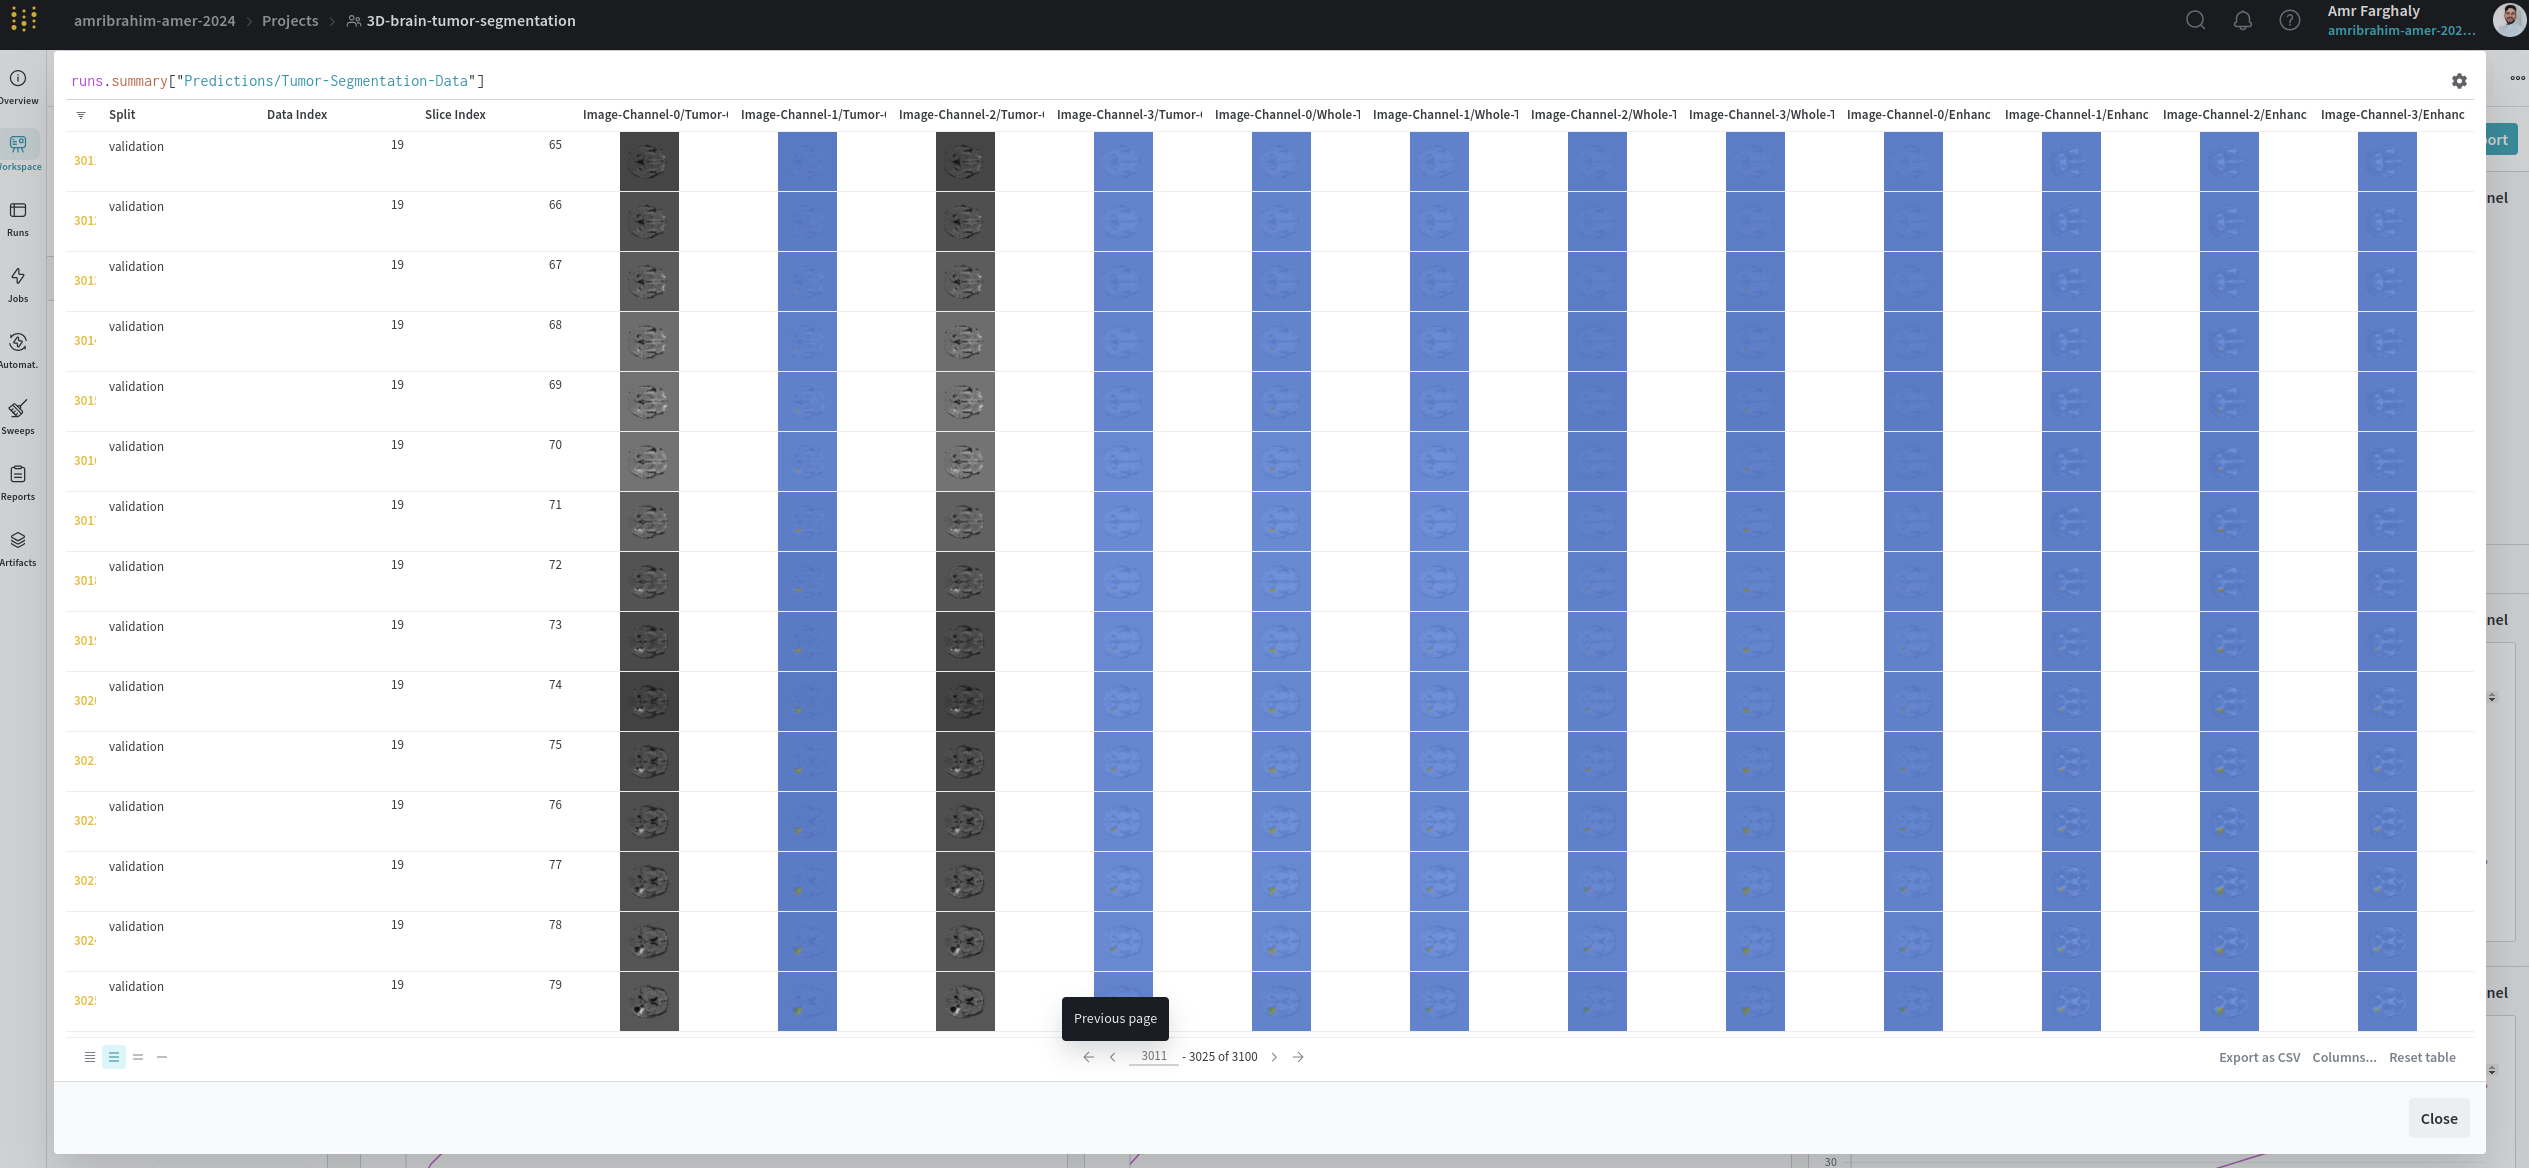  ![](https://drive.google.com/uc?id=1p1G45YnRSbkruDt6u7Wv0d_xcs4yYjmj)

